The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

EPS = 1.e-7

In [2]:
# # IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# # mount drive: WE NEED IT FOR SAVING IMAGES!
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
# results_dir = '/content/gdrive/My Drive/Colab Notebooks/TEACHING/'
results_dir = ''

In [4]:
class Digits(Dataset):
  """Scikit-Learn Digits dataset."""

  def __init__(self, mode='train', transforms=None):
    digits = load_digits()
    if mode == 'train':
      self.data = digits.data[:1000].astype(np.float32)
      self.targets = digits.target[:1000]
    elif mode == 'val':
      self.data = digits.data[1000:1350].astype(np.float32)
      self.targets = digits.target[1000:1350]
    else:
      self.data = digits.data[1350:].astype(np.float32)
      self.targets = digits.target[1350:]

    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample_x = self.data[idx]
    sample_y = self.targets[idx]
    if self.transforms:
      sample_x = self.transforms(sample_x)
    return (sample_x, sample_y)

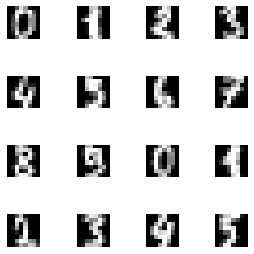

In [5]:
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4,4,figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
  for j in range(4):
    img = np.reshape(x[4*i+j],(8,8))
    axs[i,j].imshow(img, cmap='gray')
    axs[i,j].axis('off')

## 2 Neural Networks for Digits

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [6]:
# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
  def __init__(self, size):
    super(Reshape, self).__init__()
    self.size = size # a list
  
  def forward(self, x):
    assert x.shape[1] == np.prod(self.size)
    return x.view(x.shape[0], *self.size)

# This module flattens an input (tensor -> matrix) by blending dimensions 
# beyond the batch size.
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()
  
  def forward(self, x):
    return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [7]:
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction='none') #it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
      #------
      # PLEASE FILL IN
      y_pred = self.classnet(x)
      _,pred_label = torch.max(y_pred, dim = 1)
      #------
      return pred_label

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction='avg'):

      loss = self.nll(self.classnet(x),y.long())

      if reduction == 'sum':
        return loss.sum()
      else:
        return loss.mean()

**Question 1:** What is the objective function for a classification task? In other words, what is nn.NLLLos in the code above? Pelase write it in mathematical terms.

**Answer:**
nn.NLLLos is used to calculate the loss for classification tasks by assigning some weights to each class. it expect log probabilities of each class which can be archived by using LogSoftmax before it.
l(x,y)=L= {l1....lN} , ln = -Wyn*Xnyn , Wc = Weight[c].1{c!=ignore_index}
where x is the input, y is the target, w is the weight, and N is the batch size.


**Question 2:** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** Yes, it is fine because the logarithm does not change the most probable label, it changes only the probability to the log-probability.

### 2.2 Evaluation

In [8]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
  # If available, load the best performing model
  if model_best is None:
    model_best = torch.load(name + '.model')
  
  model_best.eval()# set the model to the evaluation mode
  loss_test = 0.
  loss_error = 0.
  N = 0.
  # start evaluation
  for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
    # loss (nll)
    loss_test_batch = model_best.forward(test_batch, test_targets, reduction='sum')
    loss_test = loss_test + loss_test_batch.item()
    # classification error
    y_pred = model_best.classify(test_batch)
    e = 1.*(y_pred == test_targets)
    loss_error = loss_error + (1. - e).sum().item()
    # the number of examples
    N = N + test_batch.shape[0]
  # divide by the number of examples
  loss_test = loss_test / N
  loss_error = loss_error / N

  # Print the performance
  if epoch is None:
    print(f'-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}')
  else:
    if epoch % 10 == 0:
      print(f'Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}')

  return loss_test, loss_error

# An auxiliary function for plotting the performance curves
def plot_curve(name, signal, file_name='curve.pdf', xlabel='epochs', ylabel='nll', color='b-', test_eval=None):
  # plot the curve
  plt.plot(np.arange(len(signal)), signal, color, linewidth='3', label=ylabel +' val')
  # if available, add the final (test) performance
  if test_eval is not None:
    plt.hlines(test_eval, xmin=0, xmax=len(signal), linestyles='dashed', label=ylabel +' test')
    plt.text(len(signal), test_eval, "{:.3f}".format(test_eval),)
  # set x- and ylabels, add legend, save the figure
  plt.xlabel(xlabel), plt.ylabel(ylabel)
  plt.legend()
  plt.savefig(name + file_name, bbox_inches='tight')
  plt.show()

### 2.3 Training procedure

In [9]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
  nll_val = []
  error_val = []
  best_nll = 1000.
  patience = 0

  # Main training loop
  for e in range(num_epochs):
    model.train() # set the model to the training mode
    # load batches
    for indx_batch, (batch, targets) in enumerate(training_loader):
      # calculate the forward pass (loss function for given images and labels)
      loss = model.forward(batch, targets)
      # remember we need to zero gradients! Just in case!
      optimizer.zero_grad()
      # calculate backward pass
      loss.backward(retain_graph=True)
      # run the optimizer
      optimizer.step()

    # Validation: Evaluate the model on the validation data
    loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
    nll_val.append(loss_e)  # save for plotting
    error_val.append(error_e)  # save for plotting

    # Early-stopping: update the best performing model and break training if no 
    # progress is observed.
    if e == 0:
      torch.save(model, name + '.model')
      best_nll = loss_e
    else:
      if loss_e < best_nll:
        torch.save(model, name + '.model')
        best_nll = loss_e
        patience = 0
      else:
        patience = patience + 1

    if patience > max_patience:
      break

  # Return nll and classification error.
  nll_val = np.asarray(nll_val)
  error_val = np.asarray(error_val)

  return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [10]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#### Initialize hyperparameters

In [10]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64   # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10 # the number of labels
num_kernels = 32 #the number of kernels for CNN

# -> training hyperparams
lr = 1e-3 # learning rate
wd = 1e-5 # weight decay
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped


-> START classifier_mlp
Epoch: 0, val nll=2.0125255366734094, val ce=0.38285714285714284
Epoch: 10, val nll=0.18686469623020718, val ce=0.04857142857142857
Epoch: 20, val nll=0.11588550056729997, val ce=0.03428571428571429
Epoch: 30, val nll=0.11635976416724068, val ce=0.04285714285714286
Epoch: 40, val nll=0.09216934885297502, val ce=0.03142857142857143
Epoch: 50, val nll=0.09210584061486381, val ce=0.02857142857142857
Epoch: 60, val nll=0.0793774117742266, val ce=0.02857142857142857
Epoch: 70, val nll=0.08855681121349335, val ce=0.037142857142857144
Epoch: 80, val nll=0.07278435966798237, val ce=0.03142857142857143
-> FINAL PERFORMANCE: nll=0.28921881404765765, ce=0.06711409395973154


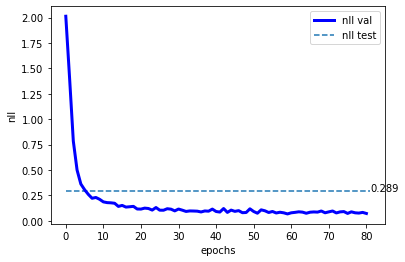

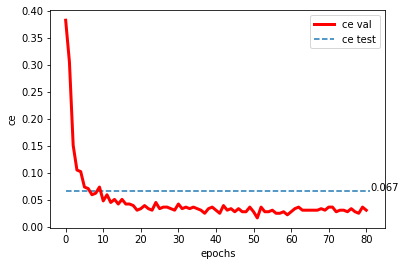


-> START classifier_cnn
Epoch: 0, val nll=1.8544747379847935, val ce=0.32571428571428573
Epoch: 10, val nll=0.10402732406343733, val ce=0.03142857142857143
Epoch: 20, val nll=0.06732511597020285, val ce=0.02
Epoch: 30, val nll=0.05184169262647629, val ce=0.017142857142857144
Epoch: 40, val nll=0.04314624007259096, val ce=0.017142857142857144
Epoch: 50, val nll=0.04684181304914611, val ce=0.017142857142857144
Epoch: 60, val nll=0.06281881257891656, val ce=0.017142857142857144
Epoch: 70, val nll=0.058627796737211094, val ce=0.02
-> FINAL PERFORMANCE: nll=0.2409133585774125, ce=0.06711409395973154


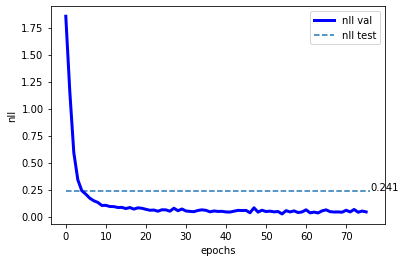

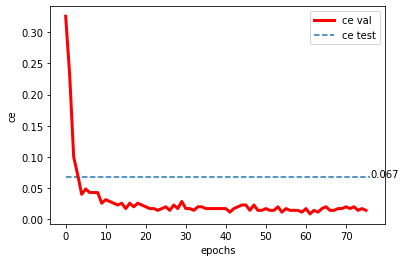

In [12]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ['classifier_mlp', 'classifier_cnn']

# loop over models
for name in names:
  print('\n-> START {}'.format(name))
  # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
  if name == 'classifier_mlp':
    name = name + '_M_' + str(M)
  elif name == 'classifier_cnn':
    name = name + '_M_' + str(M) + '_kernels_' + str(num_kernels)
  
  # Create a folder if necessary
  result_dir = os.path.join(results_dir, 'results', name + '/')
  if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

  # MLP
  if name[0:14] == 'classifier_mlp':

    classnet = nn.Sequential(nn.Linear(64,128),
                             nn.ReLU(),
                             nn.Dropout(0.2),
                             nn.Linear(128,256),
                             nn.ReLU(),
                             nn.Dropout(0.2),
                             nn.Linear(256,128),
                             nn.ReLU(),
                             nn.Dropout(0.2),
                             nn.Linear(128,64),
                             nn.ReLU(),
                             nn.Linear(64,10),
                             nn.LogSoftmax(dim=1))


  # CNN
  elif name[0:14] == 'classifier_cnn':

    classnet = nn.Sequential(Reshape((1,8,8)),
                             nn.Conv2d(1,32,3,1),
                             nn.ReLU(),
                             nn.Conv2d(32,64,3,1),
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                             nn.Dropout(0.2),
                             Flatten(),
                             nn.Linear(256,128),
                             nn.ReLU(),
                             nn.Linear(128,64),
                             nn.ReLU(),
                             nn.Linear(64,10),
                             nn.LogSoftmax(dim=1))

  # Init ClassifierNN
  model = ClassifierNeuralNet(classnet)

  # Init OPTIMIZER (here we use ADAMAX)
  optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr, weight_decay=wd) 
  
  # Training procedure
  nll_val, error_val = training(name=result_dir + name,
                                max_patience=max_patience,
                                num_epochs=num_epochs,
                                model=model,
                                optimizer=optimizer,
                                training_loader=training_loader,
                                val_loader=val_loader)
  
  # The final evaluation (on the test set)
  test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
  # write the results to a file
  f = open(result_dir + name + '_test_loss.txt', "w")
  f.write('NLL: ' + str(test_loss) + '\nCE: ' + str(test_error))
  f.close()
  # create curves
  plot_curve(result_dir + name, nll_val, file_name='_nll_val_curve.pdf', ylabel='nll', test_eval=test_loss)
  plot_curve(result_dir + name, error_val, file_name='_ca_val_curve.pdf', ylabel='ce', color='r-', test_eval=test_error)

## 2.5 Analysis

**Question 3 **: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: In terms of loss function both MLP and CNN converges on nearly same point i.e 0.2, but in terms of clasification error graph for CNN converges faster as compared to MLP. 

**Question 4 **: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: CNN is better then MLP here because of the low classification error in less epochs. CNN use kernels to extract features of image like edges and shapes etc thats why CNN is better than MLP's 

## 3 Application to Street House View Numbers (SVHN)


http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. Provide a good explanation of the applied architecture and a description of all components.
5. Analyze the results.

In [11]:
from torchvision import datasets #using SVHN dataset from torchvision
class SVHN(Dataset):

  def __init__(self, mode='train', transforms=None):
    train_set = datasets.SVHN('datasets/SVHN/train/', split='train', download=True) 
    test_set = datasets.SVHN('datasets/SVHN/test/', split='test', download=True)
    if mode == 'train':
      self.data = train_set.data[:65932].astype(np.float32)
      self.targets = train_set.labels[:65932]
    elif mode == 'val':
      self.data = train_set.data[65932:].astype(np.float32)
      self.targets = train_set.labels[65932:]
    else:
      self.data = test_set.data.astype(np.float32)
      self.targets = test_set.labels
        
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample_x = self.data[idx]
    sample_y = self.targets[idx]
    if self.transforms:
      sample_x = self.transforms(sample_x)
    return (sample_x, sample_y)

In [12]:
train_data = SVHN(mode='train')
val_data = SVHN(mode='val')
test_data = SVHN(mode='test')

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Using downloaded and verified file: datasets/SVHN/train/train_32x32.mat
Using downloaded and verified file: datasets/SVHN/test/test_32x32.mat
Using downloaded and verified file: datasets/SVHN/train/train_32x32.mat
Using downloaded and verified file: datasets/SVHN/test/test_32x32.mat
Using downloaded and verified file: datasets/SVHN/train/train_32x32.mat
Using downloaded and verified file: datasets/SVHN/test/test_32x32.mat



-> START classifier_cnn_3
Epoch: 0, val nll=1.111038399393648, val ce=0.2836860068259386
-> FINAL PERFORMANCE: nll=0.39361025236395875, ce=0.10041487400122925


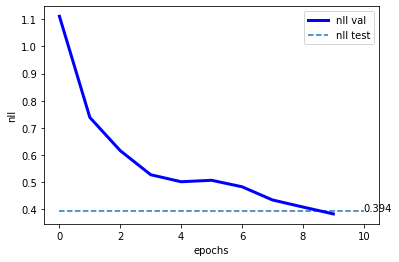

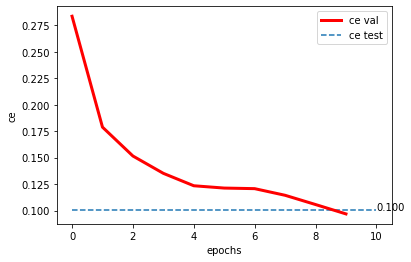

In [13]:
name = 'classifier_cnn_3'
print('\n-> START {}'.format(name))


name = name + '_M_' + str(M) + '_kernels_' + str(num_kernels)
result_dir = os.path.join(results_dir, 'results', name + '/')
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

classnet = nn.Sequential(nn.Conv2d(3,32,6,1),
                         nn.ReLU(),
                         
                         nn.Conv2d(32,32,6,1),
                         nn.MaxPool2d(2),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         
                         nn.Conv2d(32,64,6,1),
                         nn.MaxPool2d(2),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         
                         Flatten(),
                         nn.Linear(576,128),
                         nn.ReLU(),
                         
                         nn.Linear(128,64),
                         nn.ReLU(),
                         
                         nn.Linear(64,10),
                         nn.LogSoftmax(dim=1))


model = ClassifierNeuralNet(classnet)

# Init OPTIMIZER (here we use ADAMAX)
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr, weight_decay=wd) 

# Training procedure
nll_val, error_val = training(name=result_dir + name,
                            max_patience=max_patience,
                            num_epochs=10,
                            model=model,
                            optimizer=optimizer,
                            training_loader=training_loader,
                            val_loader=val_loader)
  
# The final evaluation (on the test set)
test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
# write the results to a file
f = open(result_dir + name + '_test_loss.txt', "w")
f.write('NLL: ' + str(test_loss) + '\nCE: ' + str(test_error))
f.close()
# create curves
plot_curve(result_dir + name, nll_val, file_name='_nll_val_curve.pdf', ylabel='nll', test_eval=test_loss)
plot_curve(result_dir + name, error_val, file_name='_ca_val_curve.pdf', ylabel='ce', color='r-', test_eval=test_error)

Architecture Explanation: This arch contains three convolution layers followed by the relu and maxPool2D which is used to extract important feature from the image and represent it into smaller dimension. after there is flatten layer to add fully connected layer for the classification.